# Dimensionality reduction

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Principial component analysis (PCA)

**PCA algorithm steps**

The following algorithm allows for dimension reduction from $n$ to $k$ for data set $\{ x_i: x_i\in \mathbb R^n \}_1^m$, $x = [x_i]$.

1. Preprocessing: $\mu = \frac 1m \displaystyle\sum_{i=1}^mx_i$,
2. Transform: $x_i \to x_i - \mu$,
3. Build covariance matrix: $\text{cov}(x) =\frac1m\, x^{\textsf T}x$,
4. Solve eigen problem: $\text{cov}(x) \,u_i = v_i \, u_i$,
5. Reduce dimensions: $z=U^{\textsf T} \,x$, matrix $U$ is made of $k$ eigenvectors with the largest eigenvalues $v_i$: $U = [u_1, u_2, ..., u_k]$.



## Naïve PCA

In [2]:
def naive_pca(x):
    mu = x.mean(axis=1, keepdims=True)
    xi = x - mu
    cov = 1. / x.shape[1] * xi @ xi.T
    w, u = linalg.eigh(cov)
    return u, w, mu

def proj(x, u, mu, k):
    return u[:, -k:].T @ (x - mu)

def lin_reg(x, y):
    Ex = np.average(x)
    Ey = np.average(y)
    Exy = np.average(x * y)
    Ex2 = np.average(x * x)
    theta1 = (Exy - Ex * Ey) / (Ex2 - Ex * Ex)
    theta0 = Ey - theta1 * Ex
    return theta1, theta0

## PCA vs LR

In the following example, we compare the result of linear regression (LR) and PCA applied to the same two-dimensional data.
At first one could expect that PCA and LR are equivalent in a case to line reduction, however, there is a different objective in these optimization procedures.
Namely, LR tries to minimize the following problem

$$
\text{LR:}\quad\min_\theta \sum_i \left[y_i - h_\theta(x_i)\right]^2,
$$

while the PCA minimizes the following

$$
\text{PCA:}\quad\min_u \sum_i \| x_i - \mu - u \, x_i^{\text{proj}}\|^2.
$$

As one can see LR minimizes the values $y_i$ and $h_\theta(x_i)$ and PCA minimizes the distances between points and the line.
Please note the dashed lines in the plot. The dashed line length corresponds to the minimization objective for each algorithm.

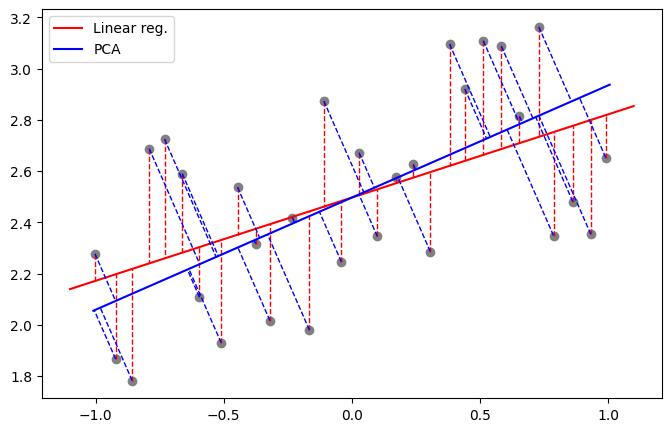

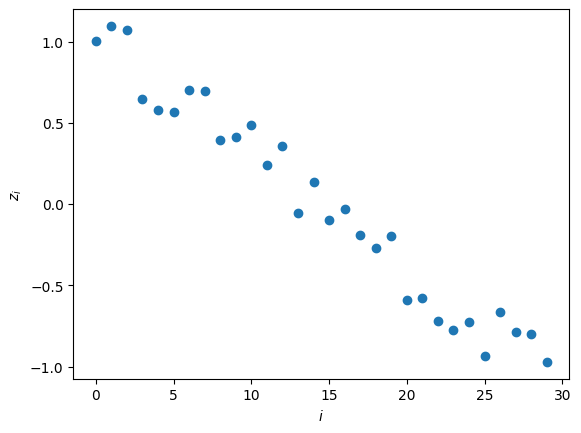

In [3]:
np.random.seed(42)

samples = 30
x = np.linspace(-1, 1, samples) + 0.01 * (2 * np.random.rand(samples) - 1)
y = +0.33 * x + np.random.rand(samples) + 2
X = np.vstack((x, y))

k = 1
u, _, mu = naive_pca(X)
x_proj = proj(X, u , mu, k)
uk = u[:, -k: ]

a, b = lin_reg(x, y)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, color='grey')

t = np.linspace(-1.1, 1.1)
reg_line = lambda x: a * x + b
ax.plot(t, reg_line(t), color='red', label='Linear reg.')
for p in np.vstack((x,y)).T:
    ax.plot([p[0], p[0]], [p[1], a * p[0] + b], 'r--', linewidth=1)

pca_line = lambda t: mu + uk * t
ax.plot(pca_line(t).T[:, 0], pca_line(t).T[:, 1], color='blue', label='PCA')

q = mu + uk @ x_proj
for p in np.vstack((X, q)).T:
    ax.plot([p[0], p[2]], [p[1], p[3]], 'b--', linewidth=1)

ax.legend()
ax.set_aspect(aspect=1)

plt.show()

fig, ax = plt.subplots()
ax.set_xlabel("$i$")
ax.set_ylabel("$z_i$")
ax.scatter(np.arange(x_proj.size), x_proj)
plt.show()

## `scikit-learn`

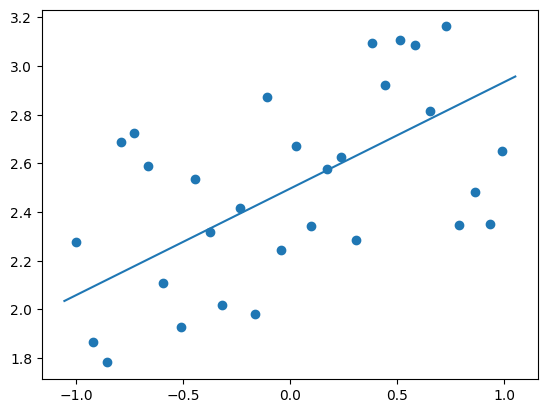

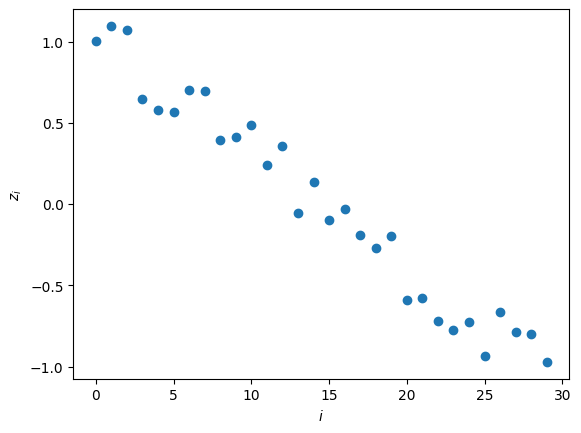

In [4]:
np.random.seed(42)

samples = 30
x = np.linspace(-1, 1, samples) + 0.01 * (2 * np.random.rand(samples) - 1)
y = +0.33 * x + np.random.rand(samples) + 2

X = np.vstack((x, y)).T
pca = PCA(n_components=1)
x_proj = pca.fit_transform(X)

u = pca.components_
mu = pca.mean_

fig, ax = plt.subplots()
ax.scatter(x, y)
line = np.vstack((mu - 1.15 * u, mu + 1.15 * u))
ax.plot(line[:, 0], line[:, 1])
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel("$i$")
ax.set_ylabel("$z_i$")
ax.scatter(np.arange(x_proj.size), x_proj)
plt.show()

## Choosing $k$

Pick the smallest $k$ for which

$$
\eta = 1 - {\displaystyle\sum_{i=1}^k v_i} \bigg/ {\displaystyle\sum_{i=1}^n v_i} \le 0.01,
$$

where $v_i$ is eigenvalue obtained during the PCA eigenproblem. It can be shown that $\eta$ corresponds to the following quantity

$$
\eta =\frac{\displaystyle\sum_i \| x_i - \mu - u \, x^{\text{proj}}_i\|^2}{\displaystyle\sum_i \| x_i - \mu \|^2}.
$$

Value of $\eta$ corresponds to fraction of variance which is retained, e.g. when $\eta=1\%$ then $99\%$ variance is retained using PCA compression.

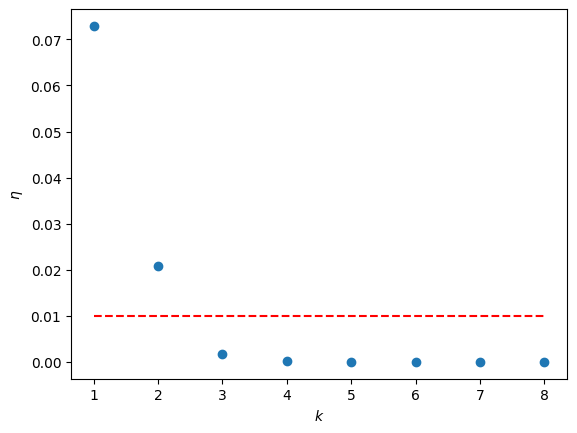

k = 3 is the smallest k for which eta <= 0.01.


In [5]:
np.random.seed(42)

def eta(w, k):
    return 1 - w[-k:].sum() / w.sum()
    
samples = 500
x = np.linspace(-1, 1, samples) + 0.01 * (2 * np.random.rand(samples) - 1)
X = np.vstack((x, -x, x**2, np.sin(x), np.abs(x), 3 * x + 0.1, np.random.rand(x.shape[0]), np.sqrt(np.abs(x), -2 * x ** 3 + 2. * x**2)))

u, w, mu = naive_pca(X)

etas = []
for i in range(w.size):
    etas.append([i+1, eta(w, i+1)])
etas = np.array(etas)

fig, ax = plt.subplots()
ax.scatter(etas[:, 0], etas[:, 1])
ax.plot([1, 8], [0.01, 0.01], 'r--')
ax.set_xlabel('$k$')
ax.set_ylabel('$\eta$')
plt.show()

print("k = 3 is the smallest k for which eta <= 0.01.")

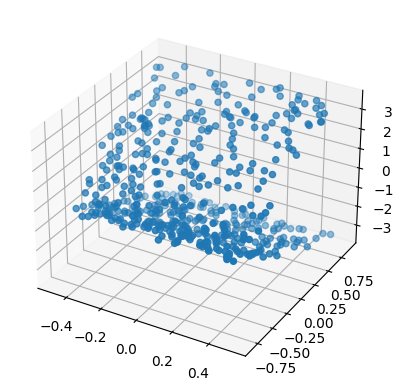

In [6]:
x_proj = proj(X, u, mu, k=3)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_proj.T[:, 0], x_proj.T[:, 1], x_proj.T[:, 2])
plt.show()